In [6]:
import os
%pwd

'c:\\Users\\karthikeya\\New_Delhi_Reviews'

In [7]:
os.chdir("c:\\Users\\karthikeya\\New_Delhi_Reviews")
%pwd

'c:\\Users\\karthikeya\\New_Delhi_Reviews'

In [3]:
from src.components.data_ingestion import DataIngestion
from src.components.text_data_transformation import DataTransformation

In [4]:
data_ingest = DataIngestion()
tr_D, ts_D = data_ingest.initate_data_ingestion()
data_trans = DataTransformation()
train_data, test_data = data_trans.initiate_data_transformation(tr_D, ts_D)

[2025-01-01 20:23:15,172, data_ingestion, INFO, Initiating data ingestion ]
[2025-01-01 20:23:15,174, data_ingestion, INFO, Establising Connection With SQL Database ]
[2025-01-01 20:23:15,176, data_ingestion, INFO, Successfully connected to the SQLite database. ]
[2025-01-01 20:23:15,178, data_ingestion, INFO, Reading New_Delhi_Reviews table  ]
[2025-01-01 20:23:15,596, data_ingestion, INFO, Successfully read the New_Delhi_Reviews as pandas dataframe ]
[2025-01-01 20:23:17,266, data_ingestion, INFO, succesfully ingested the raw data as a csv file into artifacts\raw_data.csv ]
[2025-01-01 20:23:17,267, data_ingestion, INFO, Initiating train test split ]
[2025-01-01 20:23:19,133, data_ingestion, INFO, train and test data split successful and stored respectively as csv files at artifacts\train_data.csv, artifacts\test_data.csv ]
[2025-01-01 20:23:19,170, text_data_transformation, INFO, Initiating the DataTransformation ]
[2025-01-01 20:23:19,172, text_data_transformation, INFO, Initiating

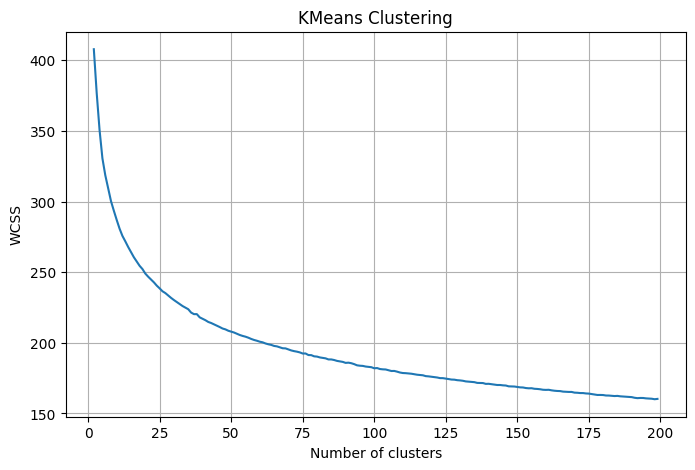

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []

for i in range(2, 200):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit_predict(train_data)
    wcss.append(kmeans.inertia_)

# 3. Visualize the results
plt.figure(figsize=(8, 5))
# Plot points with different colors based on their cluster label
plt.plot(range(2,200), wcss)
plt.title('KMeans Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
# plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

In [3]:
import warnings
import os
from dataclasses import dataclass


import pandas as pd
import joblib as jl


from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from gensim.models import KeyedVectors


from src.logger import logger
from src.components.data_ingestion import DataIngestionConfig
from src.components.data_transformation import DataTransformationConfig
from src.db_paths import fast_text_model

# Suppress warnings
warnings.filterwarnings("ignore")

In [5]:
class ClusterData(TransformerMixin, BaseEstimator):
    def __init__(self):
        logger.info("Initializing K-Means clustering model")
        try:
            self.kmeans = KMeans(n_clusters=25, random_state=42)
        except Exception as e:
            logger.error(f"Error initializing K-Means model: {e}")
            raise e

    def fit(self, X, y=None):
        try:
            logger.info("Fitting the K-Means model")
            self.kmeans.fit(X)
            return self
        except Exception as e:
            logger.error(f"Error during K-Means fitting: {e}")
            raise e

    def transform(self, X, y=None):
        try:
            logger.info("Predicting cluster labels")
            return self.kmeans.predict(X)
        except Exception as e:
            logger.error(f"Error during K-Means prediction: {e}")
            raise e


In [6]:
@dataclass
class ModellingConfig:
    model_object: str = os.path.join('artifacts', 'cluster_model.joblib')
    clustered_train_data_path: str = os.path.join('artifacts', 'clustered_train_data.csv')
    clustered_test_data_path: str = os.path.join('artifacts', 'clustered_test_data.csv')

In [7]:
class MakeEmbeddings(TransformerMixin, BaseEstimator):
    
    def __init__(self):
        logger.info("Loading Gensim Word2Vec model for embedding generation")
        try:
            self.word2vec = KeyedVectors.load_word2vec_format(fast_text_model, binary=True)
        except Exception as e:
            logger.error(f"Error loading Word2Vec model: {e}")
            raise e

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        try:
            logger.info("Generating embeddings for the text data")
            embeddings = X.iloc[:, 0].apply(
                lambda words: self.word2vec.get_mean_vector(words, ignore_missing=True)
            )
            return pd.DataFrame(embeddings.tolist())
        except Exception as e:
            logger.error(f"Error during embedding generation: {e}")
            raise e

In [9]:
class ClusterData(TransformerMixin, BaseEstimator):
    def __init__(self):
        logger.info("Initializing K-Means clustering model")
        try:
            self.kmeans = KMeans(n_clusters=25, random_state=42)
        except Exception as e:
            logger.error(f"Error initializing K-Means model: {e}")
            raise e

    def fit(self, X, y=None):
        try:
            logger.info("Fitting the K-Means model")
            self.kmeans.fit(X)
            return self
        except Exception as e:
            logger.error(f"Error during K-Means fitting: {e}")
            raise e

    def transform(self, X, y=None):
        try:
            logger.info("Predicting cluster labels")
            return self.kmeans.predict(X)
        except Exception as e:
            logger.error(f"Error during K-Means prediction: {e}")
            raise e

In [10]:
class ClusterModelling:
    def __init__(self):
        self.data_ingestion_config = DataIngestionConfig()
        self.data_trans_config = DataTransformationConfig()
        self.model_config = ModellingConfig()

    def get_cluster_model(self):
        
        return Pipeline([
            ('Make Embeddings', MakeEmbeddings()),
            ('Cluster Data', ClusterData())
        ])

    def initiate_clustering(self, train_data_path, test_data_path):
        try:
            logger.info("Initializing clustering pipeline")
            pipeline = self.get_cluster_model()

            logger.info("Loading train and test datasets")
            train_data = pd.read_csv(train_data_path)
            test_data = pd.read_csv(test_data_path)

            logger.info("Fitting and transforming train data")
            train_cluster_labels = pipeline.fit_transform(train_data)

            logger.info(f"Saving trained model at {self.model_config.model_object}")
            jl.dump(pipeline, self.model_config.model_object)

            logger.info("Transforming test data")
            test_cluster_labels = pipeline.transform(test_data)

            logger.info("Attaching cluster labels to datasets")
            train_data['cluster_id'] = train_cluster_labels
            test_data['cluster_id'] = test_cluster_labels

            train_data.to_csv(self.model_config.clustered_train_data_path, index=False)
            test_data.to_csv(self.model_config.clustered_test_data_path, index=False)

            logger.info("Clustering pipeline completed successfully")
            return train_cluster_labels, test_cluster_labels
        except Exception as e:
            logger.error(f"Error during clustering pipeline: {e}")
            raise e


In [4]:
%pwd

'c:\\Users\\karthikeya\\New_Delhi_Reviews'

In [3]:
from src.components.data_clustering import ClusterModelling
from src.components.text_data_transformation import DataTransformationConfig

data_trans_config = DataTransformationConfig()
tr_data_path, ts_data_path = data_trans_config.transformed_train_file, data_trans_config.transformed_test_file


In [4]:
cluster = ClusterModelling()
train_cluster_lables, test_cluster_labels = cluster.initiate_clustering(tr_data_path, ts_data_path)

[2025-01-01 21:14:04,001, data_clustering, INFO, Initializing clustering pipeline ]
[2025-01-01 21:14:04,003, data_clustering, INFO, Loading Gensim Word2Vec model for embedding generation ]
[2025-01-01 21:14:04,004, keyedvectors, INFO, loading projection weights from C:\Users\karthikeya\New_Delhi_Reviews\ft_reviews_vectors.bin ]
[2025-01-01 21:14:05,147, utils, INFO, KeyedVectors lifecycle event {'msg': 'loaded (106574, 25) matrix of type float32 from C:\\Users\\karthikeya\\New_Delhi_Reviews\\ft_reviews_vectors.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2025-01-01T21:14:05.147227', 'gensim': '4.3.3', 'python': '3.9.21 | packaged by conda-forge | (main, Dec  5 2024, 13:41:22) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'load_word2vec_format'} ]
[2025-01-01 21:14:05,148, data_clustering, INFO, Initializing K-Means clustering model ]
[2025-01-01 21:14:05,149, data_clustering, INFO, Loading train and test datasets ]
[2025-01-01 21:14:05,721, 